# Baselines – Next-Day Direction Prediction

Before trusting any ML model, it must clear a set of zero-parameter baselines.
A model that merely learns "the market went up today" is not useful.

| # | Baseline | What it tests |
|---|---|---|
| 1 | **Random guess** | Absolute floor (50%) |
| 2 | **Always predict Up** | Positive market drift |
| 3 | **Follow yesterday's direction** | 1-day individual momentum |
| 4 | **Follow today's market direction** | Beta / market co-movement |

The same **time-based test split** (`≥ 2023-01-01`) used in all ML notebooks is applied here so results are directly comparable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

SPLIT_DATE  = '2023-01-01'
RANDOM_SEED = 42

## 1. Load Data & Build Target

In [2]:
df = pd.read_csv('../data/merged_dataset.csv', parse_dates=['date'])
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f'Shape: {df.shape}')
print(f'Date range: {df["date"].min().date()} – {df["date"].max().date()}')
print(f'Tickers: {df["ticker"].nunique():,}')

Shape: (1264542, 43)
Date range: 2016-02-10 – 2026-02-09
Tickers: 503


In [3]:
# ── Target: is next-day return positive? ─────────────────────────────────────
# shift(-1) looks one row forward within each ticker to get tomorrow's return.
df['next_return'] = df.groupby('ticker')['daily_return'].shift(-1)
df['target']      = (df['next_return'] > 0).astype(int)

# ── Today's individual return direction (signal for momentum baseline) ────────
# daily_return is today's observable return — no shift needed.
# "Follow Yesterday" predicts tomorrow using the most recently completed day (today).
df['today_dir'] = (df['daily_return'] > 0).astype(int)

# ── Today's S&P 500 return direction ─────────────────────────────────────────
sp500_ret = (
    df.drop_duplicates('date')
    .set_index('date')['S&P500']
    .pct_change()
)
df['sp500_ret'] = df['date'].map(sp500_ret)
df['sp500_dir'] = (df['sp500_ret'] > 0).astype(int)

print('Derived columns added.')

Derived columns added.


## 2. Time-Based Test Split

Drop rows where any required column is NaN (last row per ticker has no `next_return`;
days without S&P 500 data have no `sp500_dir`).

In [4]:
required = ['target', 'today_dir', 'sp500_dir', 'daily_return']
clean    = df.dropna(subset=required)

test  = clean[clean['date'] >= SPLIT_DATE].copy()
train = clean[clean['date'] <  SPLIT_DATE].copy()

y_test = test['target'].values

print(f'Train rows : {len(train):,}  ({train["date"].min().date()} – {train["date"].max().date()})')
print(f'Test rows  : {len(test):,}   ({test["date"].min().date()}  – {test["date"].max().date()})')
print(f'\nTest class balance:')
print(f'  Up   (1): {y_test.mean():.2%}')
print(f'  Down (0): {1 - y_test.mean():.2%}')

Train rows : 839,459  (2016-02-11 – 2022-12-30)
Test rows  : 389,200   (2023-01-03  – 2026-02-09)

Test class balance:
  Up   (1): 52.23%
  Down (0): 47.77%


In [5]:
total = len(train) + len(test)
print(f'Total rows : {total:,}')
print(f'Train      : {len(train):,}  ({len(train)/total:.1%})')
print(f'Test       : {len(test):,}   ({len(test)/total:.1%})')

Total rows : 1,228,659
Train      : 839,459  (68.3%)
Test       : 389,200   (31.7%)


## 3. Define Baselines

In [6]:
rng = np.random.default_rng(RANDOM_SEED)

baselines = {
    'Random Guess':     rng.integers(0, 2, size=len(y_test)),
    'Always Up':        np.ones(len(y_test), dtype=int),
    'Follow Yesterday': test['today_dir'].values,   # sign(day T return) → predict day T+1
    'Follow Market':    test['sp500_dir'].values,
}

print('Baselines defined.')

Baselines defined.


## 4. Summary Metrics

In [7]:
summary = pd.DataFrame([
    {'Baseline': name, 'Accuracy': accuracy_score(y_test, preds)}
    for name, preds in baselines.items()
]).set_index('Baseline')

print(summary.to_string(float_format='{:.4f}'.format))

                  Accuracy
Baseline                  
Random Guess        0.5003
Always Up           0.5223
Follow Yesterday    0.4961
Follow Market       0.4881


## 5. Accuracy Bar Chart

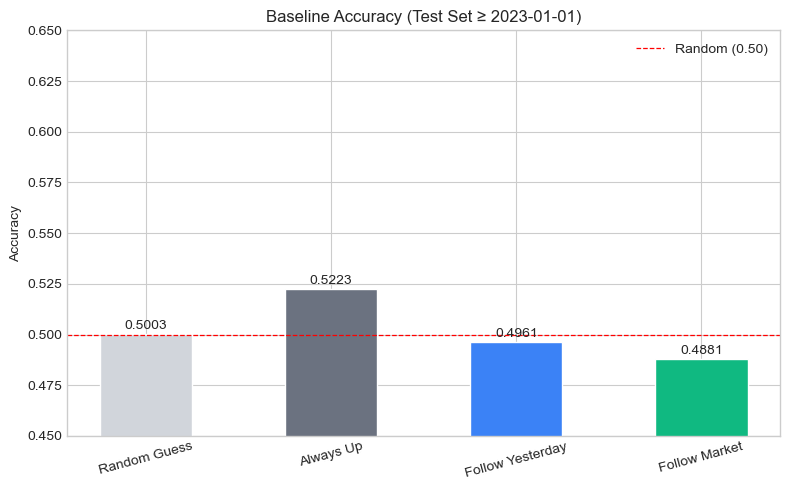

In [8]:
colors = ['#d1d5db', '#6b7280', '#3b82f6', '#10b981']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(summary.index, summary['Accuracy'], color=colors, edgecolor='white', width=0.5)
ax.set_ylim(0.45, 0.65)
ax.axhline(0.5, color='red', ls='--', lw=0.9, label='Random (0.50)')
ax.set_title('Baseline Accuracy (Test Set ≥ 2023-01-01)')
ax.set_ylabel('Accuracy')
ax.tick_params(axis='x', rotation=15)
ax.legend()
for bar, val in zip(bars, summary['Accuracy']):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.001,
        f'{val:.4f}', ha='center', va='bottom', fontsize=10,
    )
plt.tight_layout()
plt.show()

# ===============
# Cut. Anything below this is extra and may or may not be included in the final report.
# ===============

## 6. Rolling Accuracy Over Time

Baselines may perform differently across market environments.
A 60-day rolling accuracy reveals where each rule works and where it breaks down.

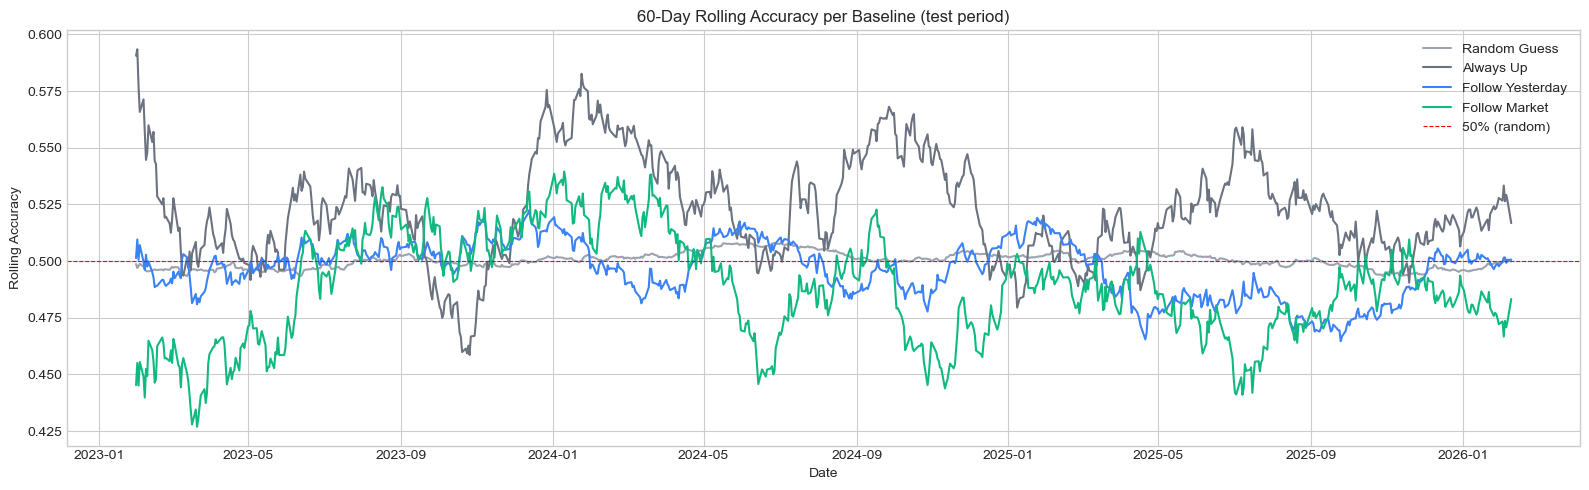

In [9]:
# Aggregate to daily level: mean accuracy across all tickers on each date
daily_results = test[['date']].copy()
daily_results['y_true'] = y_test

for name, preds in baselines.items():
    daily_results[name] = (preds == y_test).astype(int)

daily_agg = daily_results.groupby('date').mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(16, 5))

palette = {
    'Random Guess':     '#9ca3af',
    'Always Up':        '#6b7280',
    'Follow Yesterday': '#3b82f6',
    'Follow Market':    '#10b981',
}

for name, color in palette.items():
    rolling = daily_agg[name].rolling(60, min_periods=20).mean()
    ax.plot(rolling.index, rolling.values, label=name, lw=1.5, color=color)

ax.axhline(0.5, color='red', ls='--', lw=0.8, label='50% (random)')
ax.set_title('60-Day Rolling Accuracy per Baseline (test period)')
ax.set_ylabel('Rolling Accuracy')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Accuracy Conditioned on Market Direction

Key diagnostic: does the "Follow Yesterday" rule add information **beyond** what the broad market already tells us?  
Split results into "market was Up today" vs "market was Down today" and compare.

Condition         Market Down today  Market Up today  Delta (Up – Down)
Baseline                                                               
Always Up                    0.5266           0.5147            -0.0119
Follow Market                0.4734           0.5147             0.0413
Follow Yesterday             0.4874           0.5117             0.0243
Random Guess                 0.5000           0.5008             0.0008


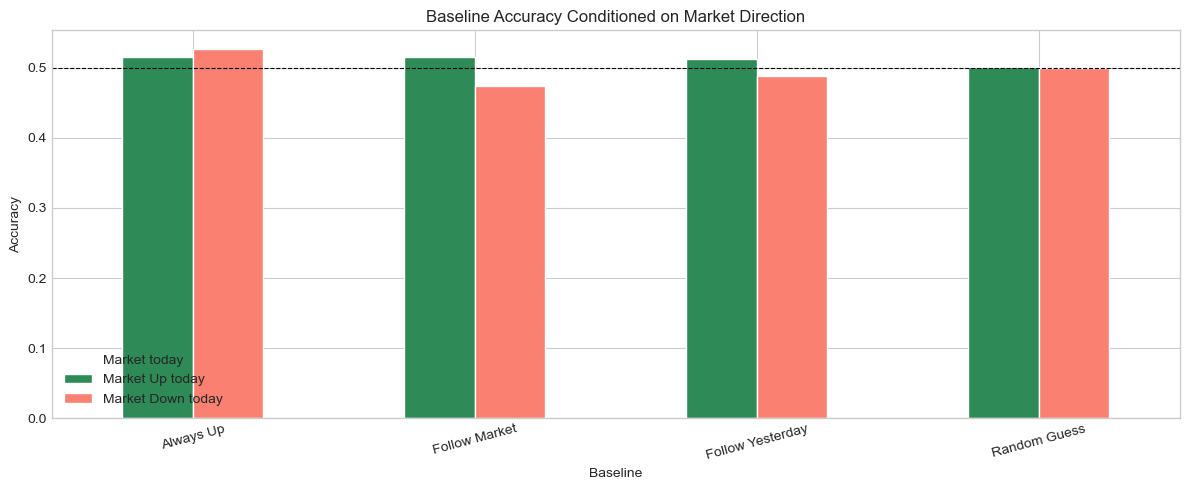

In [10]:
cond_rows = []
for market_cond, label in [(1, 'Market Up today'), (0, 'Market Down today')]:
    mask = test['sp500_dir'].values == market_cond
    y_sub = y_test[mask]
    for name, preds in baselines.items():
        acc = accuracy_score(y_sub, preds[mask])
        cond_rows.append({'Condition': label, 'Baseline': name, 'Accuracy': acc, 'N': mask.sum()})

cond_df = pd.DataFrame(cond_rows)
pivot   = cond_df.pivot(index='Baseline', columns='Condition', values='Accuracy')
pivot['Delta (Up – Down)'] = pivot['Market Up today'] - pivot['Market Down today']
print(pivot.round(4).to_string())

pivot[['Market Up today', 'Market Down today']].plot.bar(
    figsize=(12, 5), color=['seagreen', 'salmon'], edgecolor='white'
)
plt.axhline(0.5, color='black', ls='--', lw=0.8)
plt.title('Baseline Accuracy Conditioned on Market Direction')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.legend(title='Market today')
plt.tight_layout()
plt.show()

## 8. Baseline Accuracy by Sector

Which sectors are easiest / hardest to predict even with zero-parameter rules?

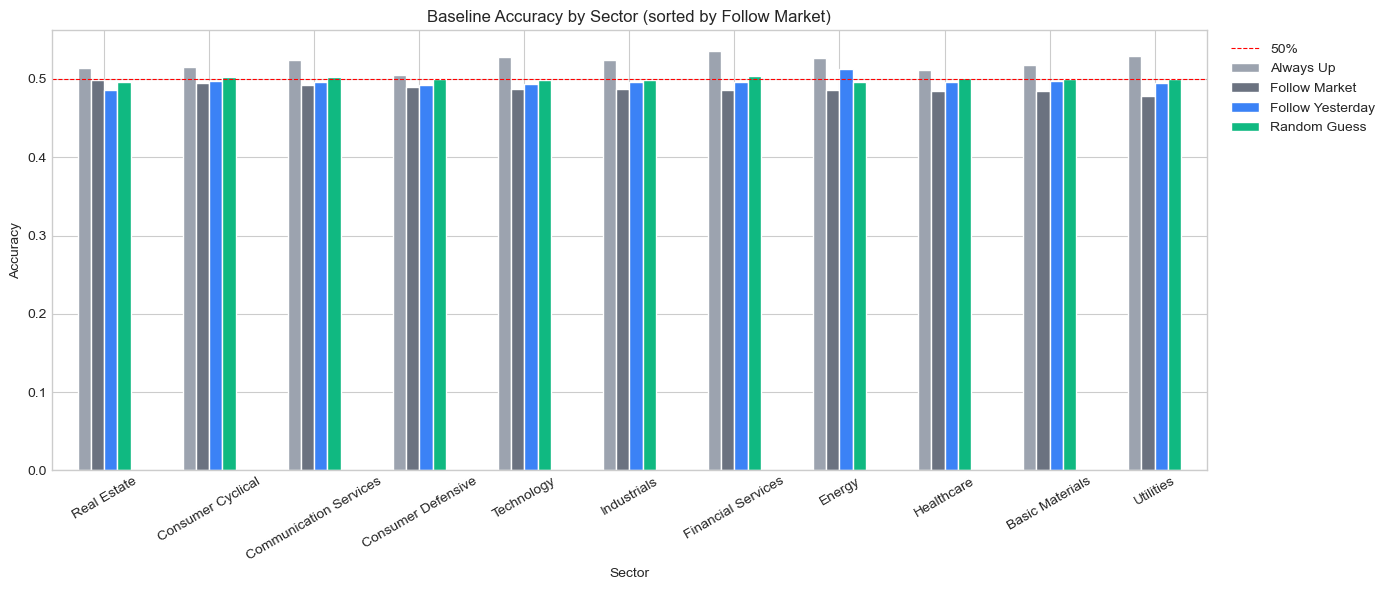

In [11]:
sector_rows = []
for sector, grp in test.groupby('Sector'):
    idx   = grp.index
    y_sub = y_test[test.index.get_indexer(idx)]
    for name, preds in baselines.items():
        p_sub = preds[test.index.get_indexer(idx)]
        sector_rows.append({
            'Sector':   sector,
            'Baseline': name,
            'Accuracy': accuracy_score(y_sub, p_sub),
        })

sector_df = pd.DataFrame(sector_rows)
pivot_s   = sector_df.pivot(index='Sector', columns='Baseline', values='Accuracy')

fig, ax = plt.subplots(figsize=(14, 6))
pivot_s.sort_values('Follow Market', ascending=False).plot.bar(
    ax=ax, color=['#9ca3af', '#6b7280', '#3b82f6', '#10b981'], edgecolor='white'
)
ax.axhline(0.5, color='red', ls='--', lw=0.8, label='50%')
ax.set_title('Baseline Accuracy by Sector (sorted by Follow Market)')
ax.set_ylabel('Accuracy')
ax.tick_params(axis='x', rotation=30)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 9. Reference Table for ML Model Comparison

Copy these numbers into any ML evaluation to compare directly.

In [13]:
print('=' * 40)
print(f'  BASELINE REFERENCE  (test ≥ {SPLIT_DATE})')
print('=' * 40)
print(f'{"Baseline":<22} {"Accuracy":>10}')
print('-' * 40)
for name, row in summary.iterrows():
    print(f'{name:<22} {row["Accuracy"]:>10.4f}')
print('=' * 40)
print()

  BASELINE REFERENCE  (test ≥ 2023-01-01)
Baseline                 Accuracy
----------------------------------------
Random Guess               0.5003
Always Up                  0.5223
Follow Yesterday           0.4961
Follow Market              0.4881

